In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
# from tools_lnd import get_T_inds, plot_FP, plot_N, plot_N3D, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
# from tools_lnd import make_lil_axes, same_stim_trial, generate_Beta_epoch, gen_X_from_model_dir_epoch, make_D_use
# from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir
from tools_lnd import same_mov_inds, get_interp_filename
from tools_lnd import bifurc, plot_bifurc_ends, take_names, gen_mov_trial_set, make_D_use, gen_trials_from_model_dir

In [10]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']##################

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'mem_motifs_small'
rule_trains = rules_dict[ruleset]
n_tasks = str(len(rule_trains))
rule_trains_str = '_'.join(rule_trains)
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '0'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# net_name = 'lr7.0l2_w6.0_h-0.0_fdgo_fdanti'
data_folder = 'data/rnn/multitask/stepnet/final'
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [11]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v5_figs','paper_figs','fig2','fig2_two_task_bifurc_cat')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [29]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) 

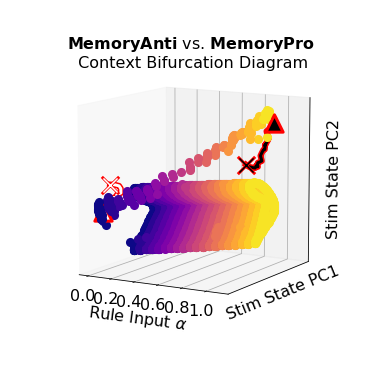

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

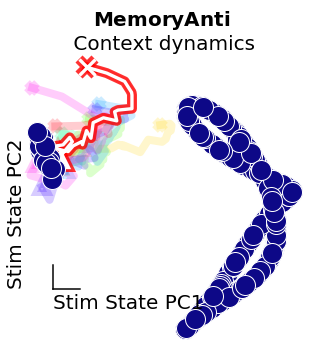

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

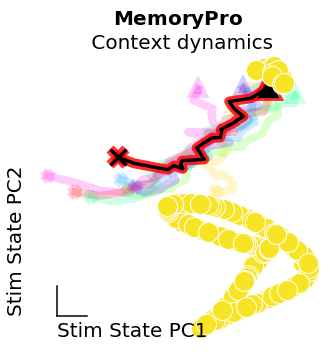

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

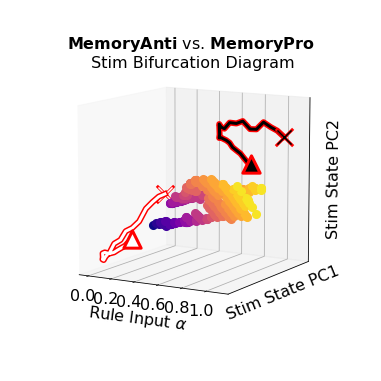

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

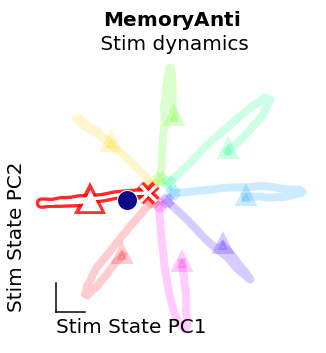

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

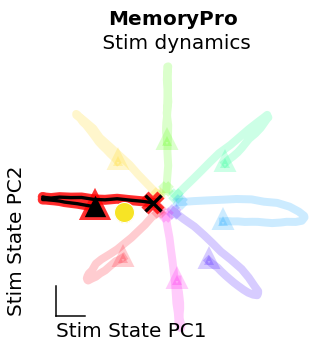

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

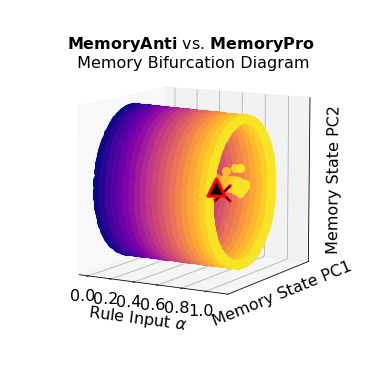

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

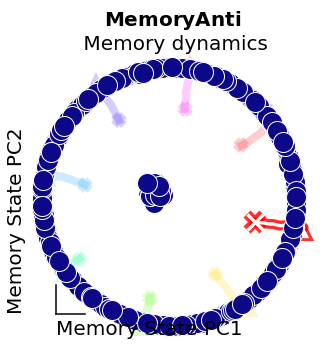

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

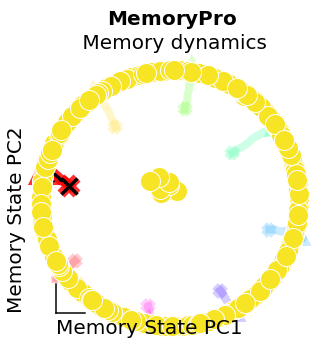

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

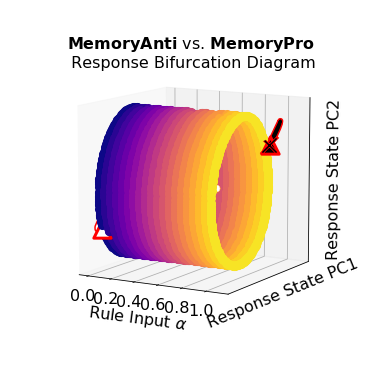

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

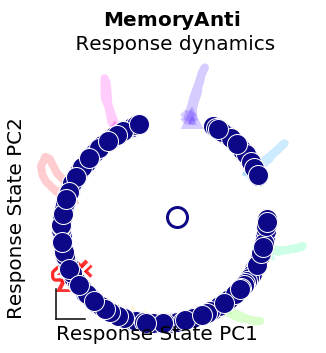

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

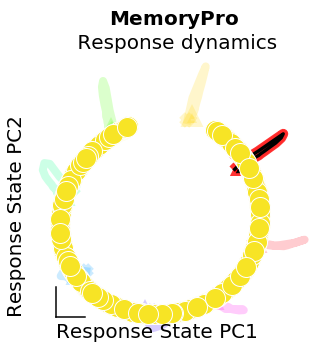

In [15]:
from tools_lnd import make_D_use, interp3d,take_names, gen_D_fp_qr, make_FP_axs

interp = True
fig_size = 5
linestyle = ['-','-']
tol_q = 1e-6
interp = True
trial_num = [0,0]
t_set = [0,0]
q_thresh = 1e-6

axs = 'pca_h_cat'

rule_set = [5,2]
rule_str = [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]]
rule_axs = 0
trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)

epoch_set = ['stim1','stim1']
rule = rules_dict['all'][rule_set[rule_axs]]
D_stim = make_FP_axs(' ', m, rule_str, epoch_set[0], axs = axs)

D_use = -D_stim
D_use[:,0] = D_stim[:,0]
D_use[:,1] = D_stim[:,1]
D_use[:,2] = D_fp_qr[:,0]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[0],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [ r"Rule Input $\alpha$",
             epoch_name_ax+' State PC1',
             epoch_name_ax+' State PC2']

epoch_set = ['fix1','fix1']
script_name = 'interp_tasks_small_init_mov'

bifurc(m,D_use,rule_set,epoch_set,script_name = script_name,q_thresh = q_thresh, rule_axs = rule_axs, 
       color_stim = True, fig_size = fig_size,fontsize = 16, figpath = figpath, ruleset = ruleset,
       ax_labels = ax_labels, stability_thresh = 1.05, lims = [],view_ang = [10, -60])

plot_bifurc_ends(m, D_use, rule_set, epoch_set, script_name, lims = [], fac_mult_lims = 2,
                 stability_thresh = 1.05, fp_first = False, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels[1],ax_labels[2]])

epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_stim'


bifurc(m,D_use,rule_set,epoch_set,script_name = script_name,q_thresh = q_thresh, rule_axs = rule_axs, 
       color_stim = True, fig_size = fig_size,fontsize = 16, figpath = figpath, ruleset = ruleset,
       ax_labels = ax_labels, stability_thresh = 1.05, lims = [],view_ang = [10, -60])

plot_bifurc_ends(m, D_use, rule_set, epoch_set, script_name, lims = [], fac_mult_lims = 2,
                 stability_thresh = 1.05, fp_first = False, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels[1],ax_labels[2]])

epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'
D_mem = make_FP_axs(' ', m, rule_str, epoch_set[0], axs = axs)
D_mem[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[0],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [ r"Rule Input $\alpha$",
             epoch_name_ax+' State PC1',
             epoch_name_ax+' State PC2']


bifurc(m,D_mem,rule_set,epoch_set,script_name = script_name,q_thresh = q_thresh, rule_axs = rule_axs, 
       color_stim = True, fig_size = fig_size,fontsize = 16, figpath = figpath, ruleset = ruleset,
       ax_labels = ax_labels, stability_thresh = 1.05, lims = [],view_ang = [10, -60])

plot_bifurc_ends(m, D_mem, rule_set, epoch_set, script_name, lims = [], fac_mult_lims = 2,
                 stability_thresh = 1.05, fp_first = False, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels[1],ax_labels[2]])


epoch_set = ['go1','go1']
D_go = make_FP_axs(' ', m, rule_str, epoch_set[0], axs = axs)
D_go[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[0],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [ r"Rule Input $\alpha$",
             epoch_name_ax+' State PC1',
             epoch_name_ax+' State PC2']


bifurc(m,D_go,rule_set,epoch_set,script_name = script_name,q_thresh = q_thresh, rule_axs = rule_axs, 
       color_stim = True, fig_size = fig_size,fontsize = 16, figpath = figpath, ruleset = ruleset,
       ax_labels = ax_labels, stability_thresh = 1.05, lims = [],view_ang = [10, -60])

plot_bifurc_ends(m, D_go, rule_set, epoch_set, script_name, lims = [], fac_mult_lims = 2,
                 stability_thresh = 1.05, fp_first = False, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels[1],ax_labels[2]])

In [31]:
# from tools
tol_q = 1e-6
script_name = 'interp_tasks_small_init_mov'
epoch_set = ['delay1','delay1']
# trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
# trial2 = gen_trials_from_model_dir(m,rule_str[1],mode='test',noise_on = False)
# trial2 = same_mov_inds(trial1, trial2) 
# trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
# save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
# filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
        
# fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
#                       filename_interp+'_step_'+str(0)+'.npz')
# fp_struct = np.load(fp_dir)
# sorted_fps = fp_struct['xstar']

# pca = PCA(n_components = 3)
# fp_pca = pca.fit_transform(sorted_fps)
# D_use = pca.components_.T
# ax_labels = 'pca_fp'

# epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
# ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC1',
#             r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC2',
#             r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC3',]

ax_labels = 'pca_h'
epoch_set = ['delay1','delay1']
D_fix = make_D_use(m,rule,epoch_set[0],ti,ax_labels)
D_use = D_fix

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

In [32]:
from tools_lnd import same_stim_trial, gen_X_from_model_dir, get_T_inds, plot_bifurc, comp_eig_decomp
from tools_lnd import axis_label_bifurc, vanilla_run_with_h0, title_label_bifurc, check_plot_zero_plane

In [33]:
def plot_bifurc(ax,x_traj,threeD,linestyle = '-',c = 'r',cd = 'k',lw = 6,alpha = 1,ms = 6):

    if threeD:
            plt.plot(x_traj[:,0],x_traj[:,1],x_traj[:,2],
                     linestyle,
                     c = c, 
                     linewidth = lw, 
                     alpha = alpha, 
                     markersize = ms)
            plt.plot(x_traj[:,0],x_traj[:,1],x_traj[:,2],
                     linestyle,
                     c = cd, 
                     linewidth = lw/2, 
                     alpha = np.min((1,alpha*2)), 
                     markersize = ms)
            
            ax.scatter(x_traj[-1,0],x_traj[-1,1],x_traj[-1,2],
                       s = 300,
                       marker = '^',
                       facecolors = cd, 
                       edgecolors = c,
                       linewidth = lw/2, 
                       alpha = alpha)
            ax.scatter(x_traj[0,0],x_traj[0,1],x_traj[0,2],
                       s = 300,
                       marker = 'x',
                       facecolors = c,
                       linewidth = lw/2, 
                       alpha = alpha)
            ax.scatter(x_traj[0,0],x_traj[0,1],x_traj[0,2],
                       s = 200,
                       marker = 'x',
                       facecolors = cd, 
                       linewidth = lw/4, 
                       alpha = alpha)
    else:
            plt.plot(x_traj[:-3,0],x_traj[:-3,1],
                     linestyle,
                     c = c, 
                     linewidth = lw, 
                     alpha = alpha, 
                     markersize = ms)
            plt.plot(x_traj[:-2,0],x_traj[:-2,1],
                     linestyle,
                     c = cd, 
                     linewidth = lw/2, 
                     alpha = alpha, 
                     markersize = ms)
            
            ax.scatter(x_traj[0,0],x_traj[0,1],
                       s = 300,
                       marker = 'x',
                       facecolors = c,
                       linewidth = lw/2, 
                       alpha = alpha)
            ax.scatter(x_traj[0,0],x_traj[0,1],
                       s = 200,
                       marker = 'x',
                       facecolors = cd, 
                       linewidth = lw/4, 
                       alpha = alpha)
            ar = ax.annotate("", xy=(x_traj[-1,:2]), xytext=(x_traj[-2,:2]),size=30,
                                    arrowprops=dict(fc=cd, ec=c,arrowstyle='simple', lw=2),)

In [34]:
def bifurc(m,D_use,rule_set,epoch_set,t_set = [0,0],script_name = 'interp_tasks_small_init_mov',
           cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['w','k'],q_thresh = .001,
           n_skip_interps=1, rule_axs = 0,ax_labels = 'pca_h', plot_unstable = True,
           color_stim = True,fig_size = 4, fontsize = 20, figpath = [],ruleset = [],
           title_y = .9, n_interp = 20,n_trials = 0, stability_thresh = 1, threeD = True,
           lims = [], view_ang = [],lw = 6,ms = 6,linestyle = '-',al_state = 1,al_fp = 1, 
           bifurc = True, plot_zero_plane = False, tol_q = 1e-6, plot_jitter = False, n_jit = 0, n_steps = 50):
    
    plt.rcParams.update({'font.size': fontsize})

    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    if threeD:
        ax = fig.add_axes([0,0,1,1], projection='3d');
    else:
        ax = fig.add_axes([0,0,1,1]);

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    epoch = epoch_set[rule_axs]
    epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule1)
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule2)

    if color_stim:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = same_stim_trial(trial1, rule_set[1]) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    else:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

    for ri in range(2):

        cd = cmap_discrete[ri]
        trial = gen_trials_from_model_dir(m,rule_str[ri],mode='test',noise_on = False)
        
        #get traj
        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
        
        #get state colors
        cmap_state = plt.get_cmap('hsv')
        if color_stim:
            c_set = np.min(trial.stim_locs[:,[0,2]],axis = 1)
            s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
            c = cmap_state(c_set[s]/(2*np.pi))
        else:
            c_set = trial.y_loc[-1,:]
            s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
            c = cmap_state(c_set[s]/(2*np.pi))
            
        #plot other trials   
        if n_trials==0:
            trial_set = range(0)
        else:
            trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/n_trials))
            
        for trial_i in trial_set:
            ci = cmap_state(c_set[trial_i]/(2*np.pi))
            x_traj_i = np.dot(x_epoch[trial_i,:,:],D_use)
            if bifurc:
                x_traj_i[:,2] = x_traj_i[:,1]
                x_traj_i[:,1] = x_traj_i[:,0]
                x_traj_i[:,0] = ri*np.ones(len(T_inds))
            plot_bifurc(ax,x_traj_i,threeD,c = ci,cd = cmap_discrete[ri],lw = lw,alpha = .1,ms = ms)
        
        #plot fp trial
        x_traj = np.dot(x_epoch[s,:,:],D_use)
        if bifurc:
            x_traj[:,2] = x_traj[:,1]
            x_traj[:,1] = x_traj[:,0]
            x_traj[:,0] = ri*np.ones(len(T_inds))
        plot_bifurc(ax,x_traj, threeD, c = c, cd = cmap_discrete[ri],lw = lw,ms = ms)

        #set x-axis to ri if bifurcation diaram
        if bifurc:
            x_traj[:,0] = ri*np.ones(len(T_inds))
            
            
    if plot_jitter:
        
        model = FixedPoint_Model(m)
        with tf.Session() as sess:
            model.restore()
            model._sigma=0
            hparams = model.hp
            alpha = hparams['dt']/hparams['tau']
            var_list = model.var_list
            params = [sess.run(var) for var in var_list]
            
        trial_set = [trial1, trial2]
        e_lims = np.zeros((2,len(trial_set)))

        for ti in range(len(trial_set)):
            trial = trial_set[ti]
            epoch = epoch_set[ti]
            e_start = max([0, trial.epochs[epoch][0]])
            e_lims[0,ti] = int(e_start)
            end_set = [np.shape(trial.x)[0], trial.epochs[epoch][1]]
            e_end = min(x for x in end_set if x is not None)
            e_lims[1,ti] = int(e_end)

        inputs_1 = trial1.x[int(e_lims[0,0]+1),t_set[0],:]
        inputs_2 = trial2.x[int(e_lims[0,1]+1),t_set[1],:]
        del_inputs = inputs_2 - inputs_1

            
    #plot fps
    for step_i in range(0,n_interp,n_skip_interps):
        
        if plot_jitter:
            step_inputs = inputs_1[np.newaxis,:]+del_inputs[np.newaxis,:]*(step_i/n_interp)
            inputs = step_inputs
#             inputs_big = inputs[np.newaxis,:]
        
        c = cmap_grad(step_i/n_interp)

        fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                              filename_interp+'_step_'+str(step_i)+'.npz')
        fp_struct = np.load(fp_dir)
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)

        for fp_ind in range(len(fp_inds)):

            fp = np.dot(sorted_fps[fp_ind,:],D_use)
            facecolors_3d = c
            fp_s = 50

            if bifurc:
                fp[2] = fp[1]
                fp[1] = fp[0]
                fp[0] = step_i/n_interp
            
            #sometimes we don't want to distinguish marginally stable fps so threshold is variable
            if np.max(eig_decomps[fp_ind]['evals'])>stability_thresh:
                if plot_unstable:
                    #open circles for unstable
                    facecolors_3d = 'w'
                    if threeD:
                        ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c,
                           facecolors = facecolors_3d, linewidth = 1/3, alpha = al_fp)
                    else:
                        ax.scatter(fp[0],fp[1],s = fp_s+20,marker = 'o',edgecolors = c,
                           facecolors = facecolors_3d, linewidth = lw/2, alpha = al_fp)
                        
                    if plot_jitter:
                
                        x_t = np.matlib.repmat(inputs,n_steps,1)
                        for jit in range(n_jit):
                            h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
                            h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
                            jitter = np.dot(h_t,D_use)
                            plt.plot(step_i/n_interp,jitter[-1,0],'^k',linewidth = .1,alpha = .1)
                            plt.plot(step_i/n_interp*np.ones(len(jitter)),jitter[:,0],'-k',linewidth = .1)

                        h_t = vanilla_run_with_h0(params, x_t, sorted_fps[fp_ind,:], hparams)
                        jitter = np.dot(h_t,D_use)
#                         plt.plot(step_i/n_interp,jitter[-1,0],'^k',c = c)
#                         plt.arrow(step_i/n_interp*np.ones(len(jitter)),jitter[:,0],'-k',c = c,linewidth = 1)
                        ar = ax.annotate("", xy=(step_i/n_interp, jitter[-1,0]), xytext=(step_i/n_interp, jitter[0,0]),
                                    arrowprops=dict(arrowstyle="->"))
                        ar.set_alpha(.1)
                        plt.plot(step_i/n_interp,jitter[0,0],'ow',linewidth = 3,markersize = 6)

            else:
                if threeD:
                    ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c,
                           facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                else:
                    ax.scatter(fp[0],fp[1],s = fp_s+20,marker = 'o',edgecolors = c,
                           facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                    
            
                    
    axis_label_bifurc(ax,ax_labels,rule_name_ax,epoch_name_ax,bifurc,threeD,fontsize)
    tit, tit_name, tit_save = title_label_bifurc(bifurc,epoch_name1,epoch_name2,rule_name1,
                                                 rule_name2,ruleset,title_y,fontsize)

    check_plot_zero_plane(ax,plot_zero_plane)
    
    if not bifurc:
        ax.set_xticks([])
        
    ax.set_yticks([])
    
    if threeD:
        
        if not plot_zero_plane:
            ax.set_zticks([])
            
        if len(view_ang)>0:
            ax.view_init(elev=view_ang[0], azim=view_ang[1])
        
        ax.dist = 12
        
    else:
        lims = []
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        

    [x1,x2] = ax.get_ylim()
    [y1,y2] = ax.get_ylim()
    lims = [x1,x2,y1,y2]

    fig_fldr = os.path.join(figpath,tit_save,ruleset)
    if not os.path.exists(fig_fldr):
        os.makedirs(fig_fldr)

    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
    plt.show()
    
    return lims


In [35]:
figpath

'/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v5_figs/paper_figs/fig2/fig2_two_task_bifurc'

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

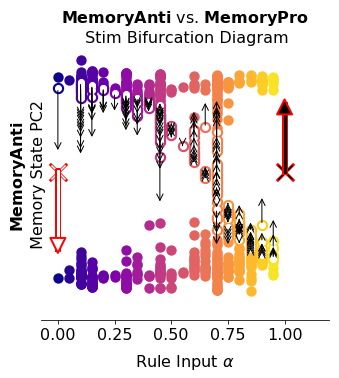

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

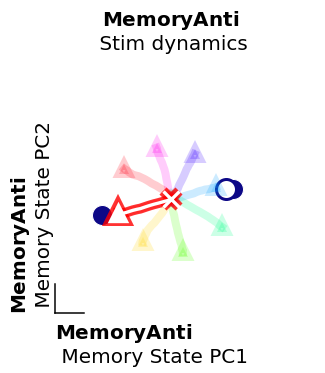

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

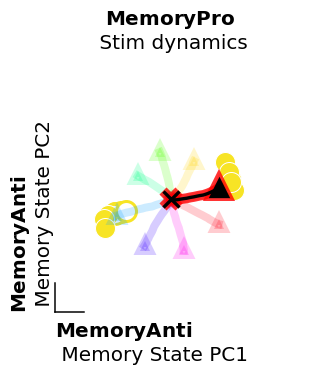

In [36]:
from tools_lnd import make_D_use, interp3d, take_names

fig_size = 4
q_thresh = .000008
interp = True
epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_stim'

ax_use = [0,1,2]
D_rotate = D_use[:,ax_use]
ax_labels = [ax_labels_master[alm] for alm in ax_use]

ax_labels[0] = r"Rule Input $\alpha$"

bifurc(m,D_rotate,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
       q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .95,
       n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
       figpath = figpath,ruleset = ruleset,ax_labels = ax_labels,
       stability_thresh = 1, lims = [], threeD = False,plot_jitter = True)

ax_use = [0,1,2]
D_rotate = D_use[:,ax_use]
ax_labels = [ax_labels_master[alm] for alm in ax_use]

plot_bifurc_ends(m,D_rotate,rule_set,epoch_set,script_name, lims = [],q_thresh = q_thresh,
                 figpath = figpath, ruleset = ruleset,ax_labels = [ax_labels_master[0],ax_labels_master[1]])

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

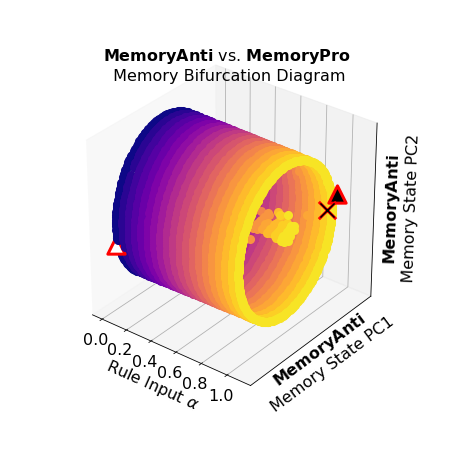

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

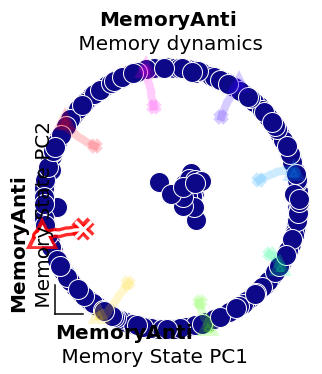

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

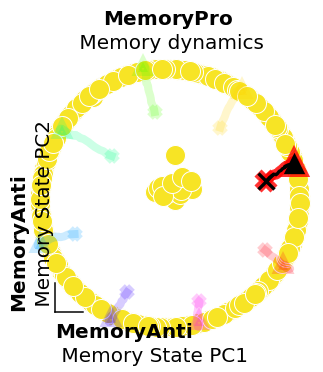

In [16]:
fig_size = 6
epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'

ax_labels = 'pca_h'
D_use = make_D_use(m,rule,epoch_set[0],ti,ax_labels)

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']

ax_labels = {}
ax_labels[1] = ax_labels_master[0]
ax_labels[2] = ax_labels_master[1]
ax_labels[0] = r"Rule Input $\alpha$"

q_thresh = .0001

lims = bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1.05, 
              lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [], fac_mult_lims = 2, q_thresh = q_thresh,
                 stability_thresh = 1.05,color_stim = True, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels[1],ax_labels[2]])

In [18]:
tol_q = 1e-6
script_name = 'interp_tasks_small_init_mov'
epoch_set = ['go1','go1']
trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
trial2 = gen_trials_from_model_dir(m,rule_str[1],mode='test',noise_on = False)
trial2 = same_mov_inds(trial1, trial2) 
trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
        
fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                      filename_interp+'_step_'+str(0)+'.npz')
fp_struct = np.load(fp_dir)
sorted_fps = fp_struct['xstar']

pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(sorted_fps)
D_use = pca.components_.T
ax_labels = 'pca_fp'

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC1',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC2',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC3',]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

In [19]:
from tools_lnd import same_stim_trial, load_fps_from_interp, plot_FPs, gen_X_from_model_dir, get_T_inds, plot_N, make_lil_axes
def plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name,tol_q = 1e-6,t_set = [0,0],
                     q_thresh = .0000001,fig_size = 4, lims = [], fac_mult_lims = 1.5,
                     stability_thresh = 1,fp_first = True, color_stim = True, step_set = [0,19],
                     figpath = 'plot_bifurc_ends',ruleset = 'all',fontsize = 20, 
                     plot_unstable = True,plot_expansion = False,ax_labels = []):
    
    cmap_discrete = ['w','k']
    cmap_grad = plt.get_cmap('plasma')

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    if color_stim:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = same_stim_trial(trial1, rule_set[1]) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    else:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))

    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
    trial_set = [trial1, trial2]

    trial_inds = range(0,np.shape(trial1.x)[1],int(np.shape(trial1.x)[1]/8))

    for ri in [0,1]:
        fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
        ax = fig.add_axes([0,0,1,1])

        sorted_fps, eig_decomps = load_fps_from_interp(m,script_name,rule_str,tol_q,filename_interp,
                                                         step_set[ri],q_thresh)

        if fp_first:
            plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], 
                stability_thresh = stability_thresh, plot_unstable = plot_unstable,
                plot_expansion = plot_expansion)
        
        rule = rule_str[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]
        print(c_master)

        trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        T_inds_plot = range(np.max([T_inds[0]-1,0]),T_inds[-1])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))


        cmap_state = plt.get_cmap('hsv')
        if color_stim:
            c_set = np.min(trial.stim_locs[:,[0,2]],axis = 1)
            s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
            c = cmap_state(c_set[s]/(2*np.pi))
        else:
            c_set = trial.y_loc[-1,:]
            s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
            c = cmap_state(c_set[s]/(2*np.pi))

        lw = 10
        plot_N(x_epoch[trial_inds,:,:], D_use.T, c_set[trial_inds], linewidth = fig_size*2, alpha = .2)
        plot_N(x_epoch[[s,],:,:], D_use.T, c, linewidth = lw, alpha = .8 ,markersize = 16)
        plot_N(x_epoch[[s,],:,:], D_use.T, c_master, linewidth = lw/3, alpha = 1 ,markersize = 16)

        if not fp_first:
            plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], 
                stability_thresh = stability_thresh, plot_unstable = plot_unstable,
                plot_expansion = plot_expansion)

        if len(lims)>0:
            ax.set_xlim([fac_mult_lims*lims[0],fac_mult_lims*lims[1]])
            ax.set_ylim([fac_mult_lims*lims[2],fac_mult_lims*lims[3]])
        else:
            # [x1,x2] = ax.get_xlim()
            # [y1,y2] = ax.get_ylim()
            # ax.set_xlim([x1-.2*abs(x1),x2+.2*abs(x2)])
            # ax.set_ylim([y1-.2*abs(y1),y2+.2*abs(y2)])
            
            ax.set_ylim([-1.15,1.15])
            ax.set_xlim([-1.15,1.15])

        epoch_name, rule_name, _, _ = take_names(epoch_set[ri],rule_str[ri])
        
        ax.set_ylim([-1.2,1.2])
        ax.set_xlim([-1.2,1.2])
        
        if len(ax_labels)>0:
            make_lil_axes(ax,ax_labels)

        ax.set_ylim([-1.2,1.2])
        ax.set_xlim([-1.2,1.2])

        tit = r"$\bf{"+rule_name+"}$"+'\n '+epoch_name+' dynamics'
        tit_name = rule_name+'_'+epoch_name+'_dynamics'
        plt.title(tit,fontsize = fontsize)#,y = .9
        fig_fldr = os.path.join(figpath,'interp_fps',ruleset,'bifurcation')
        if not os.path.exists(fig_fldr):
            os.makedirs(fig_fldr)

        plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
        plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
        plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

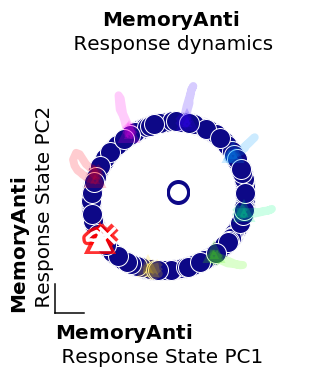

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

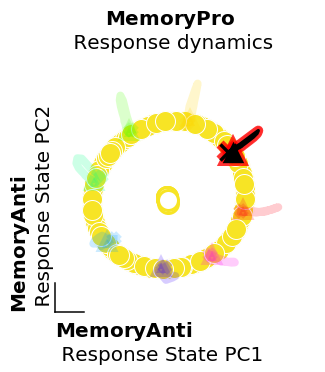

In [22]:
D_use = np.zeros((256,3))

fig_size = 6
q_thresh = .1
epoch_set = ['go1','go1']
script_name = 'interp_tasks_small_init_mov'

# filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
# fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
#                       filename_interp+'_step_'+str(0)+'.npz')

# fp_struct = np.load(fp_dir)
# sorted_fps = fp_struct['xstar']

# pca = PCA(n_components = 3)
# fp_pca = pca.fit_transform(sorted_fps)
# D_use = pca.components_.T
# D_use[:,0] = -D_use[:,0]

ax_labels = 'pca_h'
D_fix = make_D_use(m,rule,epoch_set[0],ti,ax_labels)
D_use = D_fix

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']

# lims = bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
#                        lims = [], view_ang = [31,-52])

lim_fac = 2

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2, q_thresh = q_thresh,
                 stability_thresh = 1.05, color_stim = True, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels_master[0],ax_labels_master[1]])

In [ ]:
def plot_stim_angles(ax,stim_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False, show_rainbow = True):
        
    stim_cmap = plt.get_cmap('hsv')

    [x1,x2] = ax.get_xlim()
    x_diff = (x2-x1)/10
    [y1,y2] = ax.get_ylim()
    y_diff = (y2-y1)/10
    
    x_origin = x1+5*x_diff
    y_origin = y2+y_diff

    if show_rainbow:
        for theta in stim_locs:
            c = stim_cmap(theta/(2*np.pi))
            plt.plot([x_origin,x_origin+x_diff*np.cos(theta)],
                     [y_origin,y_origin+y_diff*np.sin(theta)],'-',c = c,alpha = .5,linewidth = 5)
        
        if show_stim:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.2,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Stimulus '+r'$\theta$',fontsize = 16,fontweight ='bold')
        else:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.4,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Response '+r'$\theta$',fontsize = 16,fontweight ='bold')
    
    
    if cat_task:
        plt.text(x_origin+x_diff*np.cos(0),y_origin-y_diff*np.sin(np.pi/2),'Category \n Boundary',fontsize = 14)
        plt.plot([x_origin-x_diff*np.cos(np.pi),x_origin+x_diff*np.cos(np.pi)],
                 [y_origin-y_diff*np.sin(np.pi),y_origin+y_diff*np.sin(np.pi)],':k',alpha = .9,linewidth = 3)
        
    if two_task:
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-',c = cmap_discrete[1],alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+3.5*y_diff,marker = 'x',c = cmap_discrete[1],alpha = .9,s = 150,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+3.5*y_diff,'Task1',fontsize = 14,verticalalignment='center',fontweight ='bold')
        plt.scatter(x_origin+x_diff/2,y_origin+3.5*y_diff,marker = '^',c = cmap_discrete[1],alpha = .9,s = 80,linewidth = 4)
        
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
                 '-',c = cmap_discrete[0],alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+2.5*y_diff,marker = 'x',c = cmap_discrete[0],alpha = .9,s = 150,linewidth = 4)
        plt.scatter(x_origin+x_diff/2,y_origin+2.5*y_diff,marker = '^',c = cmap_discrete[0],alpha = .9,s = 80,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+2.5*y_diff,'Task2',fontsize = 14,verticalalignment='center',fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])


In [ ]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(.4,.5),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
stim1_locs = np.min(trial.stim_locs[0:-1:10,[0,2]],axis=1) #only workds for single modality tasks
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = True, show_rainbow = False)

figname = 'task_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'task_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [ ]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False)

figname = 'stim_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'stim_angle_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [ ]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = False)

figname = 'response_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'response_angle_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [ ]:
def interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
    cmap = plt.get_cmap('plasma')
    for step_i in range(0,n_interp,n_skip_interps):
        c = cmap(step_i/n_interp)
        ax.scatter(step_i-21.5,0,s = 200,marker = 'o',edgecolors = c,facecolors = c,alpha = al)
    plt.text(-n_interp-3,-.06,'DelayPro ---> DelayAnti',fontsize = 14,fontweight ='bold')
    plt.text(-2*n_interp-4,-.06,'Rule Input Interpolation \n   Stable Fixed Points:',fontsize = 14,fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])
#     [x1,x2] = ax.get_xlim()
#     [y1,y2] = ax.get_ylim()
#     ax.set_xlim([y1-3,y2])
    
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(2.6,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)

figname = 'interp_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'interp_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()